# Storage Benchmark

In this notebook, we'll compare the following storage formats:
- CSV: Comma-separated, standard flat text file format.
- HDF5: Hierarchical data format, developed initially at the National Center for Supercomputing Applications. It is a fast and scalable storage format for numerical data, available in pandas using the PyTables library.
- Parquet: Part of the Apache Hadoop ecosystem, a binary, columnar storage format that provides efficient data compression and encoding and has been developed by Cloudera and Twitter. It is available for pandas through the `pyarrow` library, led by Wes McKinney, the original author of pandas.

This notebook compares the performance of the preceding libraries using a test DataFrame that can be configured to contain numerical or text data, or both. For the HDF5 library, we test both the fixed and table formats. The table format allows for queries and can be appended to.

## Usage

To recreate the charts used in the book, you need to run this notebook twice up to section 'Store Result' using different settings for `data_type` and arguments for `generate_test_data` as follows:
1. `data_type='Numeric`: `numerical_cols=2000`, `text_cols=0` (default)
2. `data_type='Mixed`: `numerical_cols=1000`, `text_cols=1000`

## Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string

In [3]:
sns.set_style('whitegrid')

In [4]:
results = {}

## Generate Test Data

The test `DataFrame` that can be configured to contain numerical or text data, or both. For the HDF5 library, we test both the fixed and table format. 

In [5]:
def generate_test_data(nrows=100000, numerical_cols=2000, text_cols=0, text_length=10):
    s = "".join([random.choice(string.ascii_letters)
                 for _ in range(text_length)])
    data = pd.concat([pd.DataFrame(np.random.random(size=(nrows, numerical_cols))),
                      pd.DataFrame(np.full(shape=(nrows, text_cols), fill_value=s))],
                     axis=1, ignore_index=True)
    data.columns = [str(i) for i in data.columns]
    return data

In [6]:
data_type = 'Numeric'

In [7]:
df = generate_test_data(numerical_cols=1000, text_cols=1000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 2000 entries, 0 to 1999
dtypes: float64(1000), object(1000)
memory usage: 1.5+ GB


## Parquet

### Size

In [8]:
parquet_file = Path('test.parquet')

In [10]:
df.to_parquet(parquet_file)
size = parquet_file.stat().st_size

### Read

In [11]:
%%timeit -o
df = pd.read_parquet(parquet_file)

2.61 s ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 2.61 s ± 155 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [12]:
read = _

In [13]:
parquet_file.unlink()

### Write

In [14]:
%%timeit -o
df.to_parquet(parquet_file)
parquet_file.unlink()

16.7 s ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 16.7 s ± 157 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [15]:
write = _

### Results

In [16]:
results['Parquet'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

## HDF5

In [17]:
test_store = Path('index.h5')

函数方法

In [ ]:
key = 1
value = {'a':1}

with pd.HDFStore(test_store) as store:
    store.create_table(key, value)
    store.append(key, value)
    store.put(key, value)
    store.select(key, where='stock = stock')
    store.remove(key)

### Fixed Format

#### Size

In [18]:
with pd.HDFStore(test_store) as store:
    store.put('file', df)
size = test_store.stat().st_size

#### Read

In [19]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.get('file')

1min 17s ± 2.85 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1min 17s ± 2.85 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [20]:
read = _

In [21]:
test_store.unlink()

#### Write

In [22]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.put('file', df)
test_store.unlink()

22.5 s ± 296 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 22.5 s ± 296 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [23]:
write = _

#### Results

In [24]:
results['HDF Fixed'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

### Table Format

#### Size

In [25]:
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
size = test_store.stat().st_size    

#### Read

In [26]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    df = store.get('file')

24.3 s ± 2.62 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 24.3 s ± 2.62 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [27]:
read = _

In [28]:
test_store.unlink()

#### Write

Note that `write` in table format does not work with text data.

In [29]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
test_store.unlink()    

28.7 s ± 929 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 28.7 s ± 929 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [30]:
write = _

#### Results

In [31]:
results['HDF Table'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

### Table Select

#### Size

In [32]:
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t', data_columns=['company', 'form'])
size = test_store.stat().st_size 

#### Read

In [33]:
company = 'APPLE INC'

In [34]:
%%timeit
with pd.HDFStore(test_store) as store:
    s = store.get('file')

24.1 s ± 2.4 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [35]:
read = _

In [36]:
test_store.unlink()

#### Write

In [37]:
%%timeit
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t', data_columns=['company', 'form'])
test_store.unlink() 

27.7 s ± 546 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
write = _

#### Results

In [39]:
results['HDF Select'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

## CSV

In [40]:
test_csv = Path('test.csv')

### Size

In [41]:
df.to_csv(test_csv)
test_csv.stat().st_size

3027679709

### Read

In [42]:
%%timeit -o
df = pd.read_csv(test_csv)

14.9 s ± 501 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 14.9 s ± 501 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [43]:
read = _

In [44]:
test_csv.unlink()  

### Write

In [45]:
%%timeit -o
df.to_csv(test_csv)
test_csv.unlink()

1min 9s ± 1.82 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1min 9s ± 1.82 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [46]:
write = _

### Results

In [47]:
results['CSV'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

## Store Results

In [48]:
pd.DataFrame(results).assign(Data=data_type).to_csv(f'{data_type}.csv')

## Display Results

Please run the notebook twice as described above under `Usage` to create the two `csv` files with results for different test data.

In [50]:
df = (pd.concat([pd.read_csv('Numeric.csv', index_col=0),
      pd.read_csv('Mixed.csv', index_col=0)], axis= 1, ignore_index = True)
      .rename(columns=str.capitalize))
df.index.name='Storage'
df = df.set_index('Data', append=True).unstack()
df.Size /= 1e9

FileNotFoundError: [Errno 2] No such file or directory: 'Mixed.csv'

KeyError: 'Read'

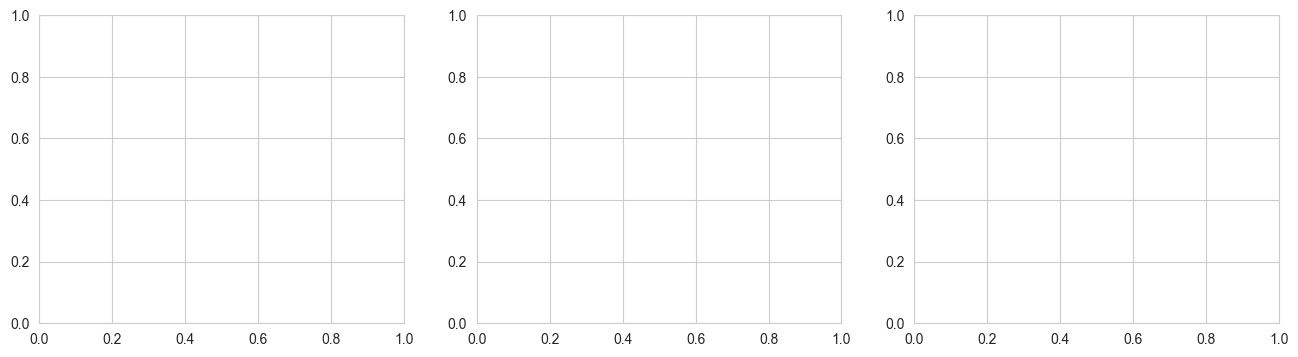

In [51]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
for i, op in enumerate(['Read', 'Write', 'Size']):
    flag= op in ['Read', 'Write']
    df.loc[:, op].plot.barh(title=op, ax=axes[i], logx=flag)
    if flag:
        axes[i].set_xlabel('seconds (log scale)')
    else:
        axes[i].set_xlabel('GB')
fig.tight_layout()
fig.savefig('storage', dpi=300);